In [1]:
"""
referensi

https://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-i-8e702ca6675b
https://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-ii-47f3a13601a2
https://www.kaggle.com/kerneler/starter-clash-royale-top-battles-91c02b8d-6
https://www.kaggle.com/freakyoiseau/analyzing-card-performance-with-regression
"""

'\nreferensi\n\nhttps://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-i-8e702ca6675b\nhttps://towardsdatascience.com/ai-cluster-analysis-of-categorical-data-part-ii-47f3a13601a2\nhttps://www.kaggle.com/kerneler/starter-clash-royale-top-battles-91c02b8d-6\nhttps://www.kaggle.com/freakyoiseau/analyzing-card-performance-with-regression\n'

# Bagian 1: Clustering

In [2]:
# Import library yang dibutuhkan
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates

In [3]:
# datasaet kartu
df = pd.read_csv("kartu.csv") # kartu.csv
# https://github.com/ichsanulamal/intro-to-AIDS/blob/master/tugas%20akhir/kartu.csv?raw=true
df = df.head(500) # tes sebagian dulu
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7
0,0,ElixirGolem,HealSpirit,eDragon,Exe,NightWitch,Rage,BattleHealer,Tornado
1,1,Sparky,RamRider,eBarbs,Musk,Prince,Tesla,Arrows,Fireball
2,2,DarkPrince,IceWiz,GoblinCage,InfernoD,Tornado,Lightning,ElectroGiant,Bomber
3,3,Witch,DarkPrince,Poison,Log,RoyalRecruits,Prince,FlyingMachine,Snowball
4,4,Bandit,Horde,Sparky,Archers,Skellies,Zap,Princess,Giant


In [4]:
# Cek missing value
def cek_null(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df)
    
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data[missing_data['Total'] > 0])

cek_null(df)


Empty DataFrame
Columns: [Total, Percent]
Index: []


In [5]:
# Cek missing value per atribut
df.isna().sum()

Unnamed: 0    0
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
dtype: int64

In [6]:
# Cek jumlah duplikasi data
df.duplicated().sum()

0

In [7]:
# Cek jumlah outliers per atribut
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1

whisker_min = Q1 - 1.5 * IQR
whisker_max = Q3 + 1.5 * IQR

((df < whisker_min) | (df > whisker_max)).sum()

<ipython-input-7-b614e6b49e0a>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df < whisker_min) | (df > whisker_max)).sum()
<ipython-input-7-b614e6b49e0a>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df < whisker_min) | (df > whisker_max)).sum()


0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
Unnamed: 0    0
dtype: int64

In [8]:
df.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   0           500 non-null    object
 2   1           500 non-null    object
 3   2           500 non-null    object
 4   3           500 non-null    object
 5   4           500 non-null    object
 6   5           500 non-null    object
 7   6           500 non-null    object
 8   7           500 non-null    object
dtypes: int64(1), object(8)
memory usage: 35.3+ KB


In [10]:
df.describe()

,Unnamed: 0
count,500.000000
mean,249.500000
std,144.481833
min,0.000000
25%,124.750000
50%,249.500000
75%,374.250000
max,499.000000


In [11]:
# Diadaptasi dari 
# https://docs.google.com/spreadsheets/d/1wIH69gfuCCoPRoWOIyUqQHMKkUfpb4GAxUbBYX8PwRc/edit#gid=1477229539
# C = pd.read_csv('https://raw.githubusercontent.com/ichsanulamal/intro-to-AIDS/master/tugas%20akhir/CRL_Cards_Classification2.csv')
C = pd.read_csv('CRL_Cards_Classification2.csv')
cards_classifier = C.copy()
cards_classifier.pop('Type_1')
cards_classifier = cards_classifier.values.transpose()
cards_classifier

# Digunakan apabila ingin sorting terlebih dahulu berdasarkan tipenya
def order_row(list1):
  # Mapping input list made of cards with their type
  card_dictionary = dict(zip(cards_classifier[0], cards_classifier[1]))
  card_dictionary

  list_tot_classification = list()
  for m in list1:
    a = card_dictionary.get(m)
    list_tot_classification.append(a)

  list_tot_classification
  #['Spell', 'Troop', 'Troop', 'Win Condition', 'Spell', 'Troop', 'Troop', 'Troop']

  # Personalized Sorting
  class_dict = {'Win Condition': 0, 'Troop': 1, 'Building': 2, 'Spell': 3}

  ## sorted by win condition, Troop, Building then Spell
  list_tot_num = list()
  for m in list_tot_classification:
    a = class_dict.get(m)
    list_tot_num.append(a)
  
  print(list_tot_num, list1)
  ordered_list = [x for _,x in sorted(zip(list_tot_num, list1))]
  return ordered_list

#example
#list1 = ['Arrows',	'Baby Dragon',	'Bomber', 'Golem',	'Lightning',	'Mega Minion',	'Mini P.E.K.K.A',	'Night Witch', 'Cannon']
#ordered_list = order_row(list1)
#ordered_list

## Labeling the Entire Dataset

In [12]:
#flat everything in one list
one_row = list()

for k in df.drop(columns="Unnamed: 0", axis=1).values:
    for n in k:
        one_row.append(n)

one_row = pd.DataFrame(one_row)
one_row

,0
0,ElixirGolem
1,HealSpirit
2,eDragon
3,Exe
4,NightWitch
...,...
3995,Log
3996,Zap
3997,MP
3998,MagicArcher


<AxesSubplot:title={'center':'Kartu paling sering digunakan'}, ylabel='Nama kartu'>

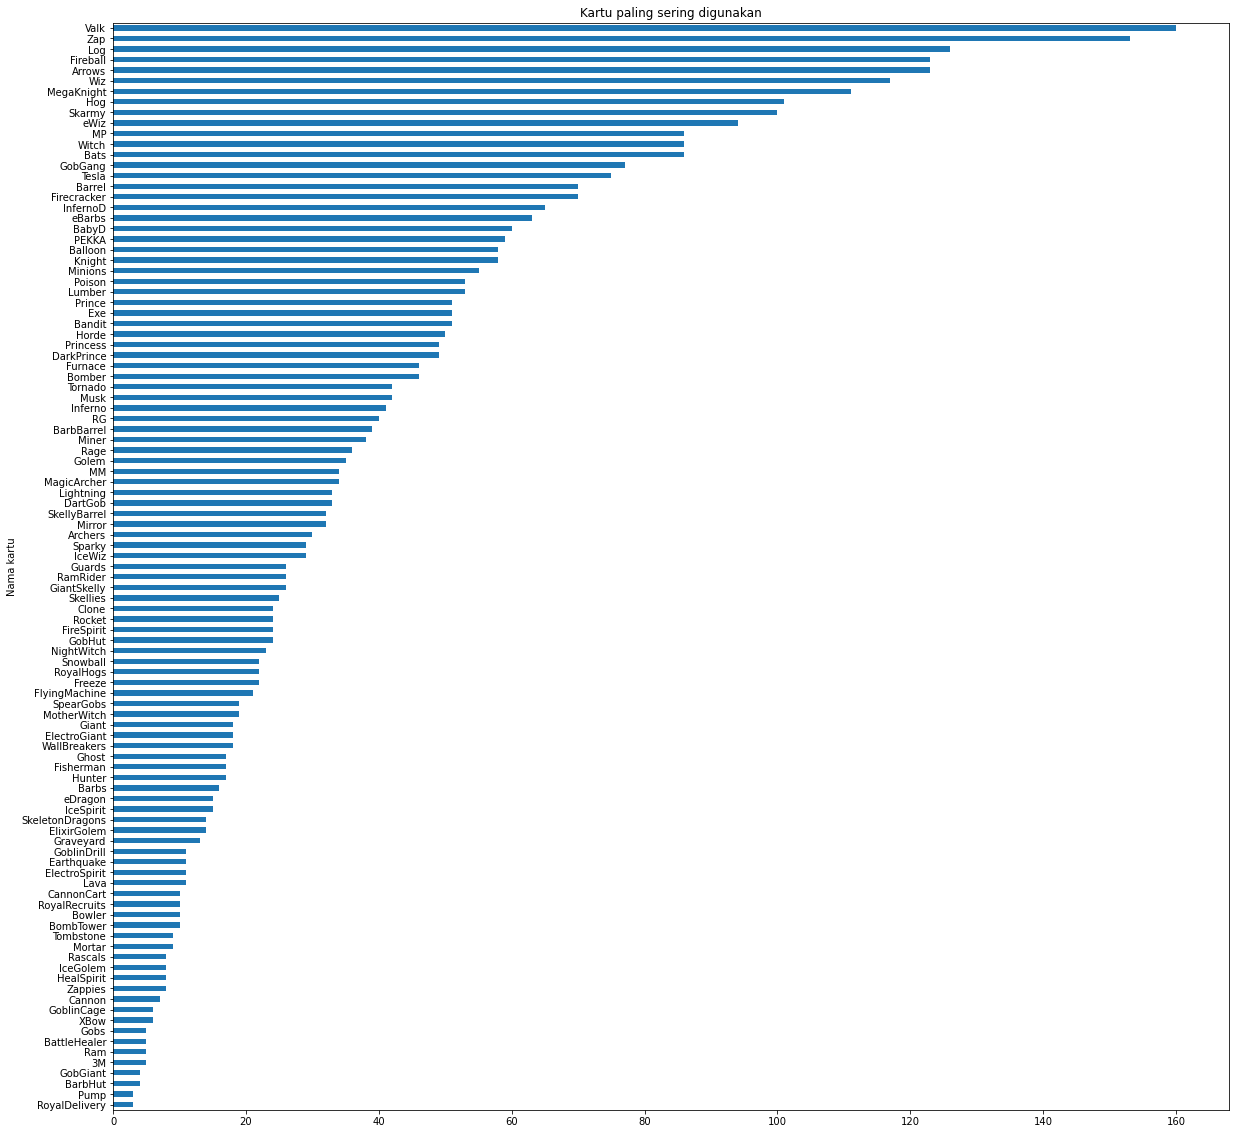

In [13]:
one_row[0].value_counts().sort_values(ascending=True).plot(kind='barh', title='Kartu paling sering digunakan',
        xlabel='Nama kartu', figsize=(20, 20))

In [14]:
#labeled list
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(one_row[0])
one_row_labeled = le.transform(one_row[0])
one_row_labeled


array([ 23,  44, 101, ...,  59,  60,  43])

In [15]:
#rebuild the original dataset and convert it to DataFrame
X_labeled = np.array_split(one_row_labeled, (len(one_row)/8))
X_labeled = pd.DataFrame(X_labeled)
X_labeled

,0,1,2,3,4,5,6,7
0,23,44,101,24,68,75,11,92
1,88,77,100,67,71,90,2,26
2,18,50,38,52,92,55,21,13
3,95,18,70,56,82,71,29,87
4,5,46,88,1,85,98,72,33
...,...,...,...,...,...,...,...,...
495,4,102,61,62,56,3,83,52
496,95,101,24,45,93,72,52,30
497,95,46,37,34,66,27,96,9
498,102,34,41,68,98,59,10,64


In [16]:
print(max(one_row_labeled+1), len(X_labeled))

103 500


Our dataset has a total of 103 cards used among players in any possible deck. This means that for every row there have to be 103 columns, each one representing a dummy variable.

In [17]:
m = np.zeros(shape=(len(X_labeled), max(one_row_labeled)+1))

print(m.shape)

for row in range(len(X_labeled)):
  for col in X_labeled.columns:
    m[row][X_labeled.loc[row, col]] = 1

m = pd.DataFrame(m)
m

(500, 103)


,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Clustering

Pada Clustering kali ini akan digunakan K-Mode. 

#### Alasan Penggunaan K-Mode

Sebelumnya, terdapat beberapa variasi algoritma clustering, dan yang dipelajari pada mata kuliah KASDD ini adalah Hierarchical clustering dan K-Means. K-Means memiliki kompleksitas waktu linier ataiu O(n) sedangkan Hierarchical clustering memiliki kompleksitas waktu kuadratik O(n^2) sehingga Hierarchical clustering kurang dapat meng-handle data yang cukup besar dengan baik. K-Mode merupakan adaptasi algoritma K-Means yang ditujukan untuk data categorical sehingga pada kasus ini digunakan K-Mode.

### Cluster Analysis

Akan dilakukan identifikasi jumlah cluster yang paling optimal

In [18]:
# #graph the number of clusters
# #utilizzando kmeans forse non è valido per questo scopo
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# wcss = []
# for i in range(1, 51):
#   km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 20, random_state = 0)
#   km.fit(m)
#   wcss.append(km.inertia_)

# plt.plot(range(1, 51), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('No. of Clusters')
# plt.ylabel('wcss')
# plt.show()

Identifikasi jumlah cluster yang paling optimal dilakukan dengan menggunakan elbow method. Biasanya, pada garis yang mulanya menurun sedikit demi sedikit terdapat titik yang kemudian mendatar sangat ekstrem. Titik itulah yang biasanya digunakan sebagai pemilihan jumlah cluster. Namun, pada grafik di atas kurang terlihat dengan jelas titik tersebut, sehingga dilakukan perkiraan di sekitar 20. Karena data yang kami gunakan bersifat categorical dan akan menggunakan K-Mode, sangat sulit untuk menentukan jumlah cluster terbaik, sehingga dipilih 20 dahulu untuk pemilihan sementara.

In [19]:
# #mapping each row to its correponding cluster
# from kmodes.kmodes import KModes
# test=KModes(n_clusters=20, init='Cao') #Huang

# cluster=test.fit_predict(m, categorical=list(m.columns))
# cluster

array([ 0, 14,  5, ...,  4, 10,  6], dtype=uint16)

In [20]:
# test.cluster_centroids_

```
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
```

20 list berikut merupakan one_hot numbers yang mendeskripsikan fitur untuk setiap single cluster. Setiap baris terdiri dari 103 elements, beberapa kolom bernilai 1, dan mayoritas bernilai 0. Untuk setiap single list, 103 binary values tersebut akan dikonversikan ke numbers, kemudian diubah menjadi nama card-nya untuk mendapatkan 20 meta-decks.

Akan dilakukan translasi dari output model K-Mode menjadi string original nya

In [21]:
#convert one_hot numbers to final decks
def archetypes(knode_list):
  archetypes_list = list()

  #for each 1 inside the one_hot cluster form return its number
  #not all clusters have the same lenght
  #store all number is arrays
  cc = list()
  for n_centroids in range(len(km.cluster_centroids_)):
    for k in range(len(km.cluster_centroids_[n_centroids])):
      if km.cluster_centroids_[n_centroids][k] == 1:
        cc.append(k)
  len(cc)

  #determines number of chunks per cluster
  n_chunks = list()
  for am in range(len(km.cluster_centroids_)):
    n_chunks.append((list(km.cluster_centroids_[am]).count(1)))
  n_chunks

  #creates the meta-decks
  from itertools import islice
  it = iter(cc)
  sliced =[list(islice(it, 0, i)) for i in n_chunks]
  sliced

  sliced_list = list()
  #convertion numbers to card names
  for o in sliced:
    sliced_list.append(list(le.inverse_transform(o)))
  
  #archetipi come si deve ma ancora disorganizzati come sorting
  #for _ in sliced_list:
  #  print(_)

  #we only conserv the win conditions
  card_dictionary = dict(zip(cards_classifier[0], cards_classifier[1]))
  card_dictionary

  #an absurd way of making a copy of our dataset, .copy() does not work
  list_tot_classification = [x[:] for x in sliced_list] 

  for o1 in range(len(list_tot_classification)):
    for o2 in range(len(list_tot_classification[o1])):
      a = card_dictionary.get(list_tot_classification[o1][o2])
      list_tot_classification[o1][o2] = a

  only_win_conditions = list()
  #only conserve lists with win conditions
  for o3 in range(len(list_tot_classification)):
    if 'Win Condition' in list_tot_classification[o3]:
      only_win_conditions.append(sliced_list[o3])

  #we store all the lists with a lenght of 8: full decks
  for _ in sorted(only_win_conditions):
    if len(_) == 8:
      archetypes_list.append(_)
    
  return archetypes_list

### Tuning Jumlah Cluster

In [22]:
# import numpy as np
# from kmodes.kmodes import KModes

# archetypes_len = list()

# arr_all = {}
# for clus in range (8, 100): ###FUNCTIONS IN A CYCLE, BUT NOT IN A FUNCTION
#   km = KModes(n_clusters=clus, init='Cao', n_init=100, verbose=0)
#   clusters = km.fit_predict(m)

#   arr_all[clus] = km.cluster_centroids_
# #25 is the optimal number of meta-decks

In [24]:
# import seaborn as sns

# archetypes_iteration = [x for x in range(8, 51)]
# archetypes_iteration

# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.scatterplot(archetypes_iteration, archetypes_len)

Dapat dilihat, semakin tinggi jumlah cluster, semakin banyak meta-decks yang serupa. 

### Kesimpulan Mengenai Jumlah Cluster:
- Jika jumlah cluster terlalu kecil, akan didapati meta-decks yang sedikit juga. Meta-decks tersebut mungkin memang merupakan yang terbaik, tetapi hanya merepresentasikan sedikit meta-decks saja, padahal terdapat meta-decks yang lainnya juga.
- Apabila jumlah cluster terlalu besar, yang didapatkan bukan hanya list dari top meta-decks saja, tetapi juga variasi dari card utama pada list meta-deck tersebut.

#### Estimasi top meta decks

Setelah dilakukan analisis lebih lanjut, jumlah cluster yang paling sesuai untuk menampilkan meta decks dengan variasi paling minimal adalah 25. Dapat disimpulkan bahwa berikut ini merupakan meta-decks pada saat dataset `kartu.csv` digunakan.

In [26]:
# # CLuster akhir
# n_clusters = 25
# km = KModes(n_clusters=n_clusters, init='Cao', n_init=100, verbose=0)
# clusters = km.fit_predict(m)

# #one_hot results to archetypes sorted by win condition
# archetypes_list = archetypes(km.cluster_centroids_)
# for _ in archetypes_list:
#   print(_)

# m["target"] = clusters

In [27]:
# m.to_csv("cluster_output.csv")

# Bagian 2: prediksi

Salah satu permasalahan besar clash royale ada pada deck building. Banyak pemain tahu beberapa kartu yang ingin mereka pakai, tetapi tidak tahu kartu mana yang paling baik untuk melengkapi deck mereka. Pada bagian ini akan diberikan rekomendasi kartu yang perlu ditambahkan berdasarkan inputan dari pemain.

Berdasarkan clustering yang telah dilakukan di awal, telah didapatkan jumlah cluster yang cukup optimal, yaitu sebanyak 25 cluster. Untuk memberikan rekomendasi kartu pelengkap pada pemain berdasarkan kartu yang diinputnya, bisa digunakan berbagai model klasifikasi. Akan dicoba berbagai model tersebut untuk dilihat berbagai metricnya.

## Preprocessing

In [28]:
from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    

def evaluate_classifier_performance(y_pred, y_test, classifier):
    # Informasi evaluasi secara compact
    
    print("Hasil Evaluasi:\n\n%s\n" % (classification_report(y_test, y_pred)))

    # Butuh informasi lebih lengkap? silakan disimak di bawah ini
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision Macro Average:', precision_score(y_test, y_pred, average='macro'))
    print('Precision Micro Average:', precision_score(y_test, y_pred, average='micro'))
    print('Recall Macro Average:', recall_score(y_test, y_pred, average='macro'))
    print('Recall Micro Average:', recall_score(y_test, y_pred, average='micro'))
    print('F1 Macro Average:', f1_score(y_test, y_pred, average='macro'))
    print('F1 Micro Average:', f1_score(y_test, y_pred, average='micro'))

    # Confusion Matrix
    print("\n\nConfusion Matrix\n")
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=classifier.classes_).plot()

In [29]:
m = pd.read_csv("cluster_output.csv")


In [30]:
m.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '94', '95', '96', '97', '98', '99', '100', '101', '102', 'target'],
      dtype='object', length=105)

In [31]:
from sklearn.model_selection import train_test_split

X = m.drop(columns=["target", "Unnamed: 0"], axis=1)
y = m["target"]

# Membentuk 4 variabel X_train, X_test, y_train, dan y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=2021)

## Train Model 

#### KNeighborsClassifier
Berikut adalah hasil evaluasi klasifikasi dataset apabila menggunakan KNeighborsClassifier

#### Naive Bayes
Berikut adalah hasil evaluasi klasifikasi dataset apabila menggunakan Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
bayes_pred = bayes.predict(X_test)

Hasil Evaluasi:

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      8043
           1       0.79      0.79      0.79      4617
           2       0.71      0.67      0.69      1842
           3       0.52      0.69      0.59      1075
           4       0.80      0.75      0.77      2429
           5       0.91      0.65      0.76      1680
           6       0.67      0.90      0.77       913
           7       0.66      0.85      0.74       455
           8       0.76      0.89      0.82      4670
           9       0.71      0.86      0.78      2574
          10       0.69      0.78      0.73      2500
          11       0.64      0.72      0.68      2381
          12       0.79      0.77      0.78      1657
          13       0.61      0.67      0.64       867
          14       0.87      0.53      0.66      1037
          15       0.49      0.77      0.60      1562
          16       0.71      0.57      0.63      1119
          

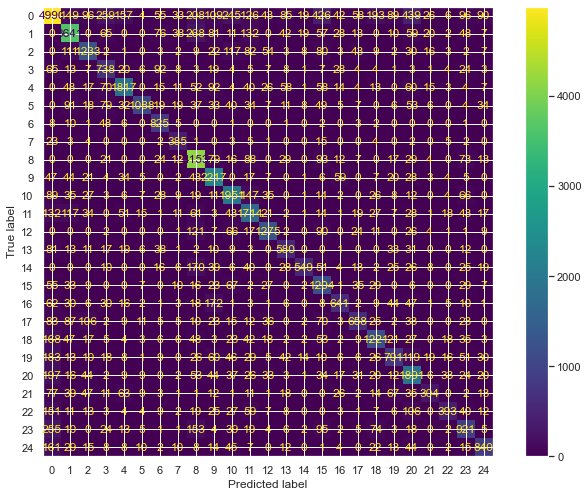

In [33]:
# Memanggil fungsi evaluasi untuk MLP Classifier
evaluate_classifier_performance(bayes_pred, y_test, bayes)

#### Decision Tree (Gini & Entropy)
Berikut adalah hasil evaluasi klasifikasi dataset apabila menggunakan Decision Tree. Kali ini menggunakan variasi Gini & Entropy untuk Decision Tree.

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

classifier_dt_gini = DecisionTreeClassifier(max_depth = 10, random_state = 2021, criterion='gini')
classifier_dt_gini.fit(X_train, y_train)
y_pred_dt_gini = classifier_dt_gini.predict(X_test)

classifier_dt_entropy = DecisionTreeClassifier(max_depth = 10, random_state = 2021, criterion='entropy')
classifier_dt_entropy.fit(X_train, y_train)
y_pred_dt_entropy = classifier_dt_entropy.predict(X_test)

Hasil Evaluasi:

              precision    recall  f1-score   support

           0       0.91      0.53      0.67     13865
           1       1.00      0.98      0.99      4718
           2       1.00      0.92      0.96      1996
           3       0.84      0.44      0.58      2054
           4       0.99      0.96      0.98      2499
           5       1.00      0.89      0.94      1880
           6       0.61      0.95      0.74       586
           7       0.03      0.54      0.05        24
           8       1.00      0.99      1.00      4699
           9       0.99      0.98      0.99      2604
          10       1.00      0.97      0.98      2576
          11       0.86      0.97      0.91      2111
          12       0.99      0.98      0.98      1685
          13       0.26      0.98      0.41       232
          14       1.00      0.98      0.99      1050
          15       0.65      0.67      0.66      1517
          16       0.75      0.95      0.84       878
          

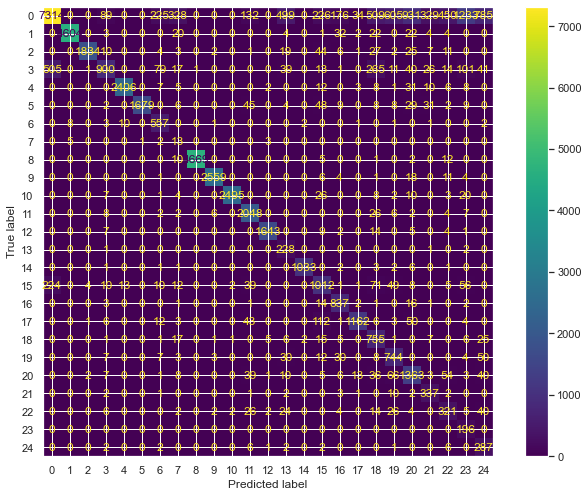

In [35]:
# Evaluasi Varian Gini
evaluate_classifier_performance(y_test, y_pred_dt_gini, classifier_dt_gini)

Hasil Evaluasi:

              precision    recall  f1-score   support

           0       0.92      0.58      0.71     12620
           1       1.00      0.98      0.99      4715
           2       0.99      0.96      0.98      1913
           3       0.82      0.95      0.88       930
           4       0.96      0.96      0.96      2435
           5       1.00      0.91      0.95      1850
           6       0.61      0.96      0.75       581
           7       0.03      0.65      0.05        20
           8       1.00      0.99      1.00      4699
           9       1.00      1.00      1.00      2575
          10       1.00      0.98      0.99      2552
          11       0.89      0.96      0.93      2205
          12       0.99      0.99      0.99      1671
          13       0.99      0.94      0.96       910
          14       0.99      0.98      0.98      1039
          15       0.26      0.95      0.40       423
          16       0.38      0.49      0.43       863
          

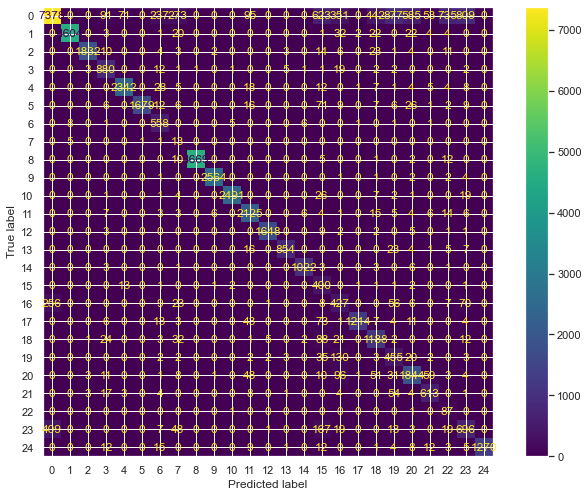

In [36]:
# Evaluasi Varian Entropy
evaluate_classifier_performance(y_test, y_pred_dt_entropy, classifier_dt_entropy)

Dapat dilihat secara overall, model terbaik pada kasus percobaan ini adalah decision tree. Dengan demikian, rekomendasi mengenai kartu yang perlu ditambahkan agar menjadi meta-deck sudah dapat dibuat. Karena aplikasi ini memiliki tujuan untuk rekomendasi, alternatif lain yang bisa dilakukan adalah dapat diberikan beberapa prediksi sekaligus. Contohnya apabila menggunakan KNN, bisa ditambahkan sekitar 10 data terdekatnya dan diberikan rekomendasi pada pemain. Bisa juga apabila menggunakan Naive Bayes memilih beberapa cluster dengan peluang tertinggi untuk direkomendasikan pada pemain. Namun, pada kasus ini kami hanya merekomendasikan 1 deck saja yang paling meta pada pemain sesuai inputannya.     

> rm later, can't be explained
Namun, hasil ini belum tentu dapat diandalkan. Kembali lagi pada masalah awal, yaitu clustering, data mentah pada awal memang sudah dilabeli dengan clusternya yang sesuai. Akan tetapi, karena yang akan dibuat adalah rekomendasi meta-deck dari suatu input dari pemain

# Extras: Agar hasil prediksi bisa dibaca manusia

In [37]:
def to_one_hot_encoding(a):
    a = le.transform(a)

    print(a)

    m = np.zeros(max(one_row_labeled)+1)
    
    for it in a:
        m[it] = 1

    return m

In [38]:
def to_card(a):
    arr = []
    
    for it in range(len(a[0])):
        if a[0][it] == 1:
            arr.append(it)

    return le.inverse_transform(arr)
        

In [47]:
# Naive Bayes
a = ['Inferno', 'Poison', 'Zap']

c = bayes.predict(np.reshape(to_one_hot_encoding(a), (1,-1)))

c

[51 70 98]


array([4], dtype=int64)

In [48]:
x_input = to_one_hot_encoding(a)
m_copy = m.copy()
for i in range(len(x_input)):
  if x_input[i] == 1:
    m_copy = m_copy[m_copy[str(i)] == 1]

print(m_copy)

[51 70 98]
        Unnamed: 0    0    1    2    3    4    5    6    7    8  ...   94  \
28              28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1294          1294  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2351          2351  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4508          4508  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
5304          5304  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
123176      123176  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
124489      124489  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
126329      126329  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
126809      126809  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
127567      127567  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

         95   96   97   98   99  100  101  102  target  
28     

In [49]:
for ind, r in m_copy[m_copy["target"] == c[0]].drop(columns=["target"], axis=1).iterrows():
  arr = []
  for i in range(len(r)):
    if r[i] == 1:
      arr.append(i)

  print(arr)

[27, 36, 49, 52, 71, 75, 96, 99]
[30, 52, 58, 71, 72, 78, 94, 99]
[44, 52, 63, 64, 71, 72, 94, 99]
[22, 28, 36, 52, 67, 71, 97, 99]
[6, 36, 52, 71, 72, 73, 77, 99]
[9, 52, 57, 65, 71, 75, 99, 102]
[5, 52, 62, 71, 93, 97, 99, 103]
[14, 28, 34, 52, 71, 94, 97, 99]
[26, 40, 46, 52, 60, 71, 94, 99]
[25, 46, 49, 50, 52, 54, 71, 99]
[15, 46, 52, 54, 64, 71, 99, 103]
[19, 38, 52, 71, 72, 75, 96, 99]
[41, 46, 52, 58, 68, 71, 94, 99]
[11, 52, 63, 68, 71, 72, 95, 99]
[19, 32, 52, 62, 71, 72, 99, 103]
[44, 46, 52, 60, 71, 94, 97, 99]
[15, 20, 52, 64, 71, 75, 94, 99]
[46, 50, 52, 68, 71, 86, 94, 99]
[27, 52, 60, 64, 71, 89, 97, 99]
[34, 36, 52, 53, 71, 97, 99, 103]
[20, 34, 52, 58, 71, 93, 97, 99]
[19, 36, 50, 52, 63, 71, 73, 99]
[7, 40, 46, 52, 60, 71, 94, 99]
[22, 25, 32, 52, 62, 71, 99, 103]
[34, 52, 62, 64, 71, 94, 96, 99]
[52, 58, 71, 72, 89, 94, 97, 99]
[18, 35, 52, 64, 71, 73, 81, 99]
[51, 52, 60, 63, 64, 71, 90, 99]
[36, 46, 52, 57, 62, 64, 71, 99]
[49, 50, 52, 63, 68, 71, 86, 99]
[19, 28,

In [ ]:
#not used in the algorithm, but useful

#converter cards to labels
a = le.transform(['The Log', 'Ice Wizard',	'Wall Breakers',	'Tornado',	'Bomb Tower', 'Rocket', 'Goblins', 'Valkyrie', 'Miner'])
list(a)

#converter labels to cards
a = le.inverse_transform([2, 5, 40, 53, 64, 86])
list(a)